<a href="https://colab.research.google.com/github/2024-WISET-F16/wiset-ai-models/blob/kwakminjung%2Fmodels/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

linear_stack Parameter containing:
tensor([[ 0.1936,  0.2375, -0.4300,  0.3841, -0.0959],
        [-0.3008,  0.0834, -0.1494, -0.4367, -0.1091],
        [-0.0195, -0.1489, -0.3016, -0.2014, -0.3271],
        [-0.0138,  0.1462,  0.2543, -0.2894,  0.2517],
        [ 0.0106,  0.0937,  0.3047,  0.1582,  0.1990],
        [ 0.1766, -0.2830,  0.3044,  0.4314, -0.4418]], requires_grad=True)
linear_stack Parameter containing:
tensor([-0.3295,  0.3169,  0.0323,  0.2261, -0.2561,  0.2309],
       requires_grad=True)
epoch = 0, current loss = 64691.1562
epoch = 100, current loss = 28784.4844
epoch = 200, current loss = 18080.6738
epoch = 300, current loss = 14472.1621
epoch = 400, current loss = 12890.0391
epoch = 500, current loss = 11913.3164
epoch = 600, current loss = 11141.7656
epoch = 700, current loss = 10460.9170
epoch = 800, current loss = 9836.4248
epoch = 900, current loss = 9256.5293
epoch = 1000, current loss = 8715.9346
epoch = 1100, current loss = 8211.3047
epoch = 1200, current los

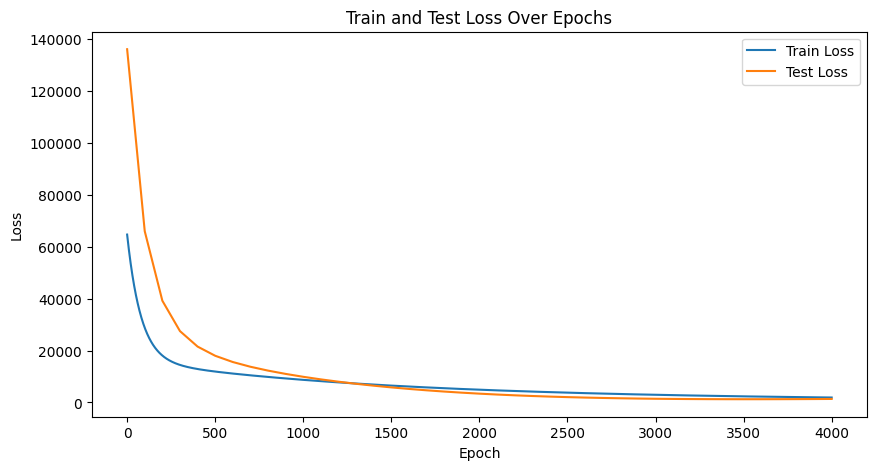

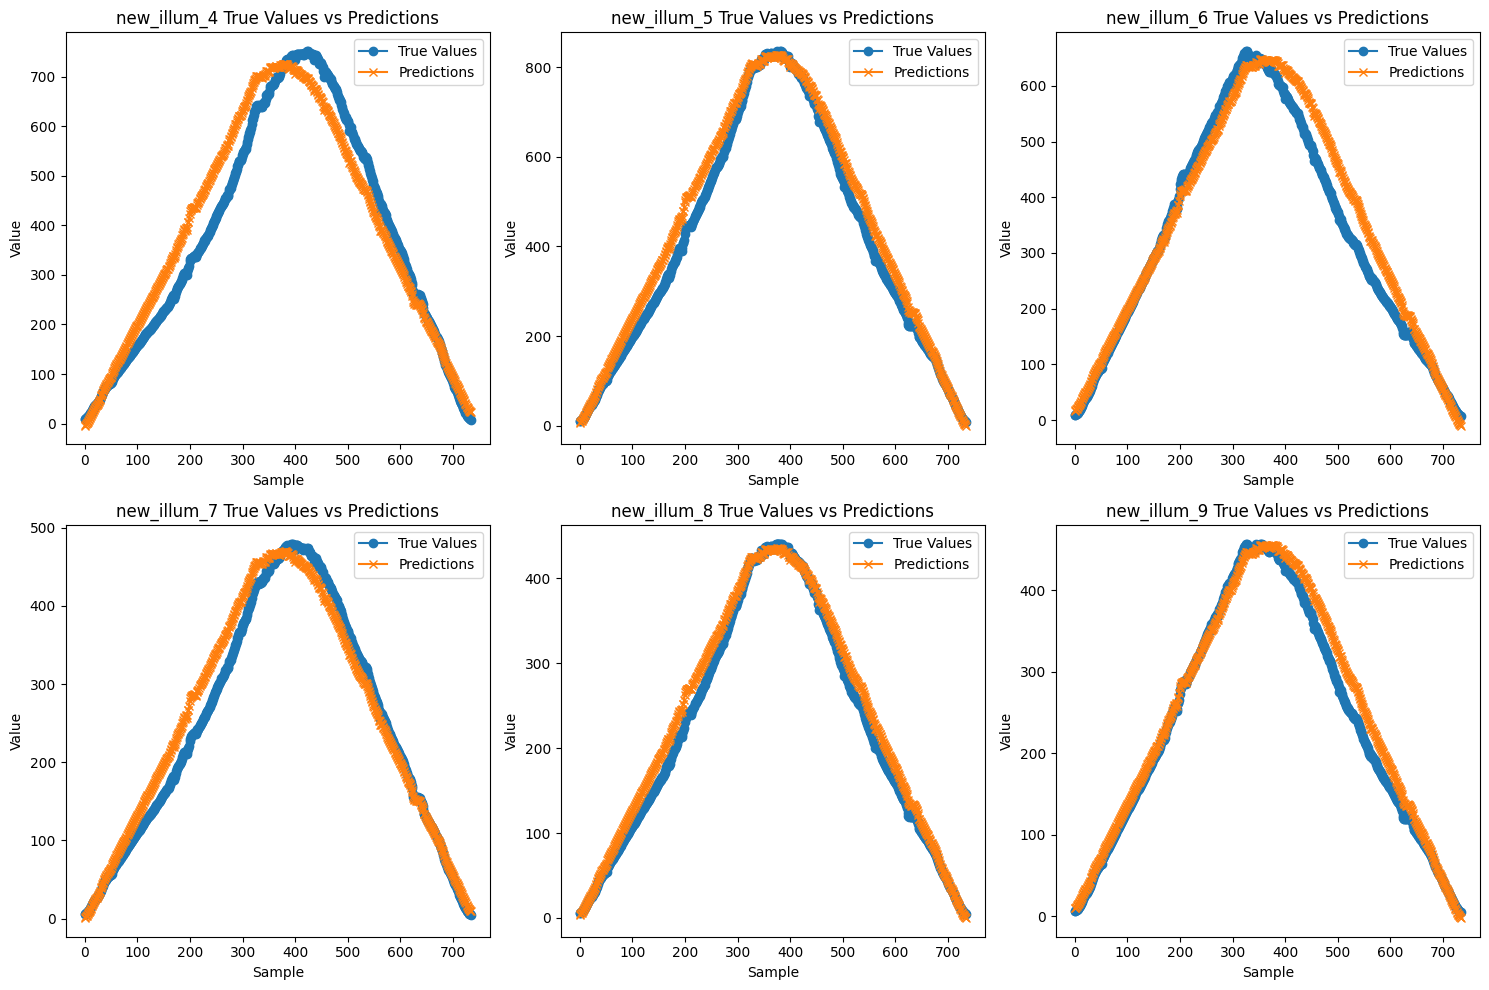

new_illum_4 mean absolute error: 49.8261833190918
new_illum_5 mean absolute error: 32.39838790893555
new_illum_6 mean absolute error: 32.0278205871582
new_illum_7 mean absolute error: 21.162656784057617
new_illum_8 mean absolute error: 13.9443359375
new_illum_9 mean absolute error: 13.971077919006348


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

training_dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/wiset_train_data_20240329-20240513.xlsx')
test_dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/wiset_test_data_20240407.xlsx')

# training dataset 준비
# azimuth or elevation 'dark' 일 경우 제외
mask = ~(training_dataset['azimuth'].str.contains('dark') | training_dataset['elevation'].str.contains('dark'))
training_dataset = training_dataset[mask]

X_train_pd = training_dataset.iloc[:, 1:6]
y_train_pd = training_dataset.iloc[:, 6:]

# 결측값 제거
X_train_pd = X_train_pd.dropna()
y_train_pd = y_train_pd.dropna()

# ===================

# X_train 정규화
scaler = MinMaxScaler()

X_train_np = scaler.fit_transform(X_train_pd.astype(np.float32))
y_train_np = y_train_pd.astype(np.float32).to_numpy()

X_train = torch.Tensor(X_train_np).float()
y_train = torch.Tensor(y_train_np).float()

# test dataset 준비
X_test_pd = test_dataset.iloc[:, 1:6]
X_test_np = scaler.fit_transform(X_test_pd.astype(np.float32))

X_test = torch.Tensor(X_test_np).float()

y_test_pd = test_dataset.iloc[:, 6:]
y_test_np = y_test_pd.astype(np.float32).to_numpy()

y_test = torch.Tensor(y_test_np).float()

# ====================

# 선형회귀 모델
class MyLinearRegressionModel(nn.Module):

  def __init__(self, input_nodes, output_nodes):
    super().__init__()
    self.linear_stack = nn.Sequential(
        nn.Linear(input_nodes, output_nodes)
    )

  def forward(self, data):
    prediction = self.linear_stack(data)

    return prediction

# input_nodes: 5, ouput: 6
model = MyLinearRegressionModel(5, 6)

# w1,w2,w3,w4,w5 and bias
for name, child in model.named_children():
  for param in child.parameters():
    print(name, param)

# loss function (mean square)
loss_function = nn.MSELoss()

# optimizer: 경사하강법
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

train_loss_list = []
test_loss_list = []
nums_epoch = 4000
eval_interval = 100

for epoch in range(nums_epoch + 1):
  model.train()

  # loss function 계산
  prediction = model(X_train)
  loss = loss_function(prediction, y_train)

  train_loss_list.append(loss.item())

  # 역전파
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % eval_interval == 0:
    print(f'epoch = {epoch}, current loss = {loss.item():.4f}')

    # test의 loss 계산
    model.eval()
    with torch.no_grad():
      test_predictions = model(X_test)
      test_loss = loss_function(test_predictions, y_test)
      test_loss_list.append(test_loss.item())

print(f'Final train loss: {train_loss_list[-1]:.4f}')
print(f'Final test loss: {test_loss_list[-1]:.4f}')

# loss function plot
plt.figure(figsize=(10, 5))
plt.plot(range(nums_epoch + 1), train_loss_list, label='Train Loss')
plt.plot(range(0, nums_epoch + 1, eval_interval), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()
plt.show()

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    ax = axs[i // 3, i % 3]
    ax.plot(y_test_np[:, i], label='True Values', marker='o')
    ax.plot(test_predictions.numpy()[:, i], label='Predictions', marker='x')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Value')
    ax.set_title(f'new_illum_{i + 4} True Values vs Predictions')
    ax.legend()

plt.tight_layout()
plt.show()

for i in range(6):
    mae = mean_absolute_error(y_test_np[:, i], test_predictions.numpy()[:, i])
    print(f'new_illum_{i + 4} mean absolute error: {mae}')